## 梯度下降训练模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv(r'C:\Users\刘子瑞\Desktop\train.csv')

查看数据大致信息

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       700 non-null    float64
 1   y       699 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB


查看缺失值

In [4]:
data.isnull().sum()

x    0
y    1
dtype: int64

y出现了缺失值

In [5]:
data[data.isnull().any(axis = 1)]

,x,y
213,3530.157369,NaN


删除该缺失数据

In [6]:
data.dropna(inplace = True)

检查重复数据

In [7]:
data[data.duplicated()]

,x,y


没有重复值

In [8]:
data.describe()

,x,y
count,699.000000,699.000000
mean,50.014306,49.939869
std,28.954560,29.109217
min,0.000000,-3.839981
25%,25.000000,24.929968
50%,49.000000,48.973020
75%,75.000000,74.929911
max,100.000000,108.871618


In [9]:
x = data['x'].values.reshape(-1,1)
y = data['y'].values.reshape(-1,1)

进行标准化加速收敛

In [10]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

查看原数据

In [11]:
X_train , X_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)

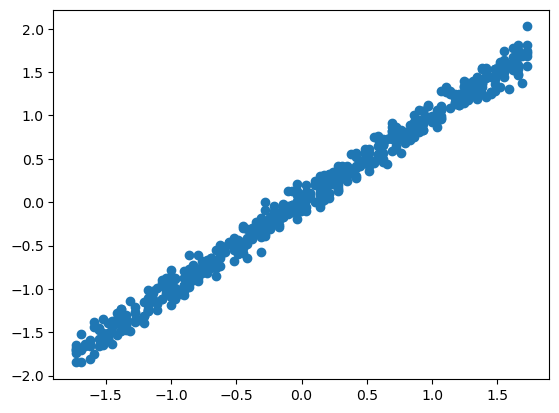

In [12]:
plt.scatter(X_train,y_train)
plt.show()

由于样本较小，这里采用批量梯度下降(BGD)

In [13]:
alpha = 0.01
iteration = 1000
sample = len(data)
w_b = np.random.rand(2,1)

In [14]:
wb_bgd = []
MSE_bgd = []

In [15]:
X_b = np.c_[np.ones((len(X_train), 1)), X_train]

In [16]:
for i in range(iteration):
    gradients = 2 / sample * X_b.T.dot(X_b.dot(w_b) - y_train)  
    w_b = w_b - alpha * gradients 
    MSE_loss = np.mean((X_b.dot(w_b) - y_train) ** 2)
    wb_bgd.append(w_b.copy())
    MSE_bgd.append(MSE_loss)

In [17]:
w = []
b = []
b = [w_b[0][0] for w_b in wb_bgd]
w = [w_b[1][0] for w_b in wb_bgd]

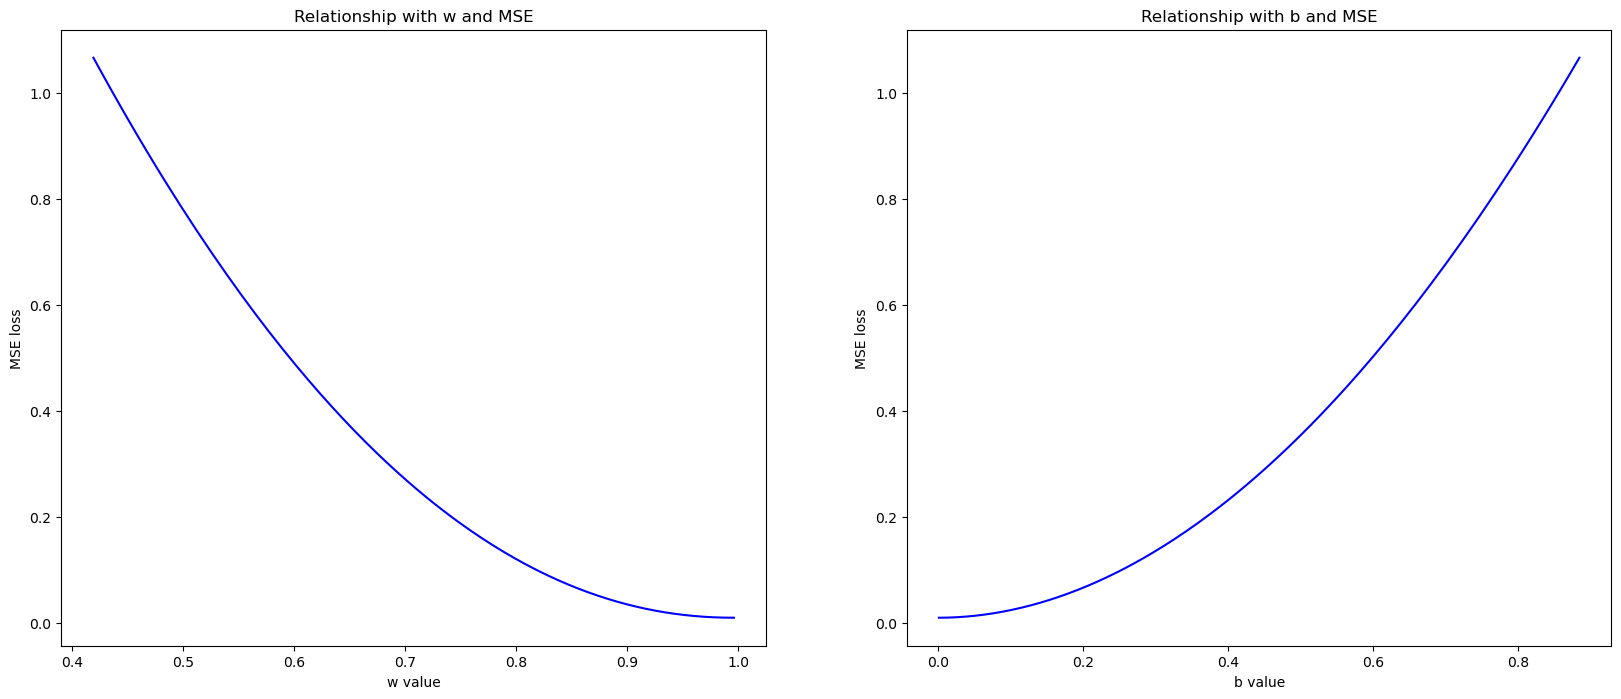

In [18]:
plt.figure(figsize = (20 , 8))

plt.subplot(1,2,1)
plt.title('Relationship with w and MSE')
plt.plot(w , MSE_bgd , 'b')
plt.xlabel('w value')
plt.ylabel('MSE loss')

plt.subplot(1,2,2)
plt.title('Relationship with b and MSE')
plt.plot(b , MSE_bgd , 'b')
plt.xlabel('b value')
plt.ylabel('MSE loss')
plt.show()

通过批量梯度下降发现w,b收敛

绘制wx+b的图像

In [19]:
best_w = w[-1]
best_b = b[-1]

In [20]:
def function(x):
    x_array = np.array(x)
    return best_w * x_array + best_b

训练集与拟合直线

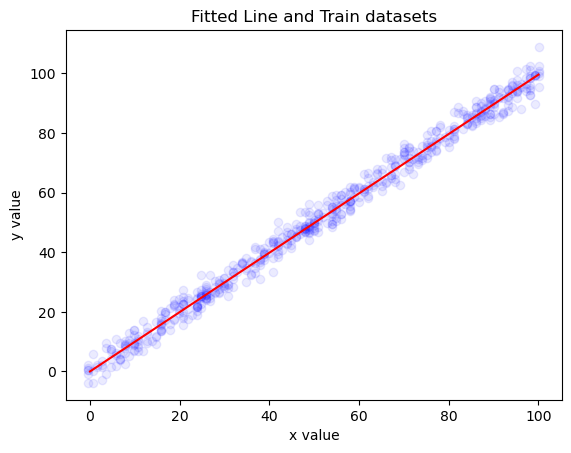

In [21]:
plt.scatter(scaler.inverse_transform(X_train),scaler.inverse_transform(y_train),color = 'b',alpha = 0.08)
plt.plot([0,20,40,60,100],function([0,20,40,60,100]),color = 'red')
plt.title('Fitted Line and Train datasets')
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

测试集效果

In [22]:
r2 = r2_score(y_test,function(X_test))

r2: 0.991


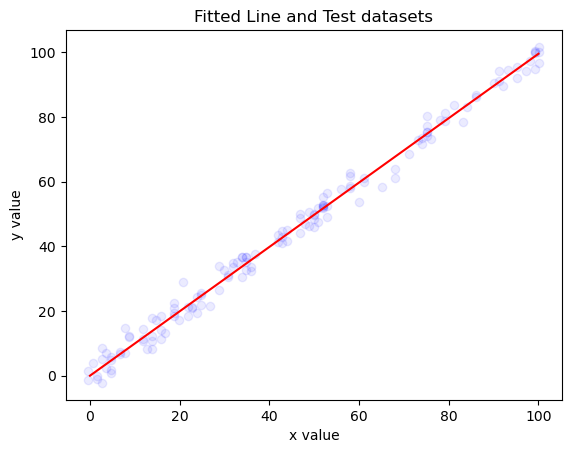

In [23]:
plt.scatter(scaler.inverse_transform(X_test),scaler.inverse_transform(y_test),color = 'b',alpha = 0.08)
plt.plot([0,20,40,60,100],function([0,20,40,60,100]),color = 'red')
plt.title('Fitted Line and Test datasets')
plt.xlabel('x value')
plt.ylabel('y value')
print('r2:',round(r2,3))
plt.show()

##  PyTorch标准建模流程

In [24]:
import torch.nn as nn
import torch

### 读取数据，数据初始化处理

In [25]:
X_train , X_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)

In [26]:
X_train = torch.tensor(X_train , requires_grad = True).float()
y_train = torch.tensor(y_train , requires_grad = True).float()
X_test = torch.tensor(X_test , requires_grad = True).float()
y_test = torch.tensor(y_test , requires_grad = True).float()


### 初始化w,b

In [27]:
w_b = np.random.rand(2,1)
w = w_b[1][0]
b = w_b[0][0]
w = torch.tensor(w , requires_grad = True).float()
b = torch.tensor(b , requires_grad = True).float()

### 构建模型

In [28]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel,self).__init__()
        self.linear = torch.nn.Linear(1,1)
    
    def forward(self,x):
        y_pred = self.linear(x)
        return y_pred

### 构建损失和优化器

In [29]:
model = LinearModel()

In [30]:
alpha = 0.08

In [31]:
criterion = torch.nn.MSELoss(size_average = False)

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [32]:
optimizer_adagrad = torch.optim.Adagrad(model.parameters(),lr = alpha)

### 循环训练

由于后面需要使用多个优化器进行训练，且步骤类似，使用函数封装

#### 选择优化器

In [33]:
# 选择优化器 
def optimizer_selector(X_train, y_train , alpha , interation , criterion , optimizer_class):
    optimizer = optimizer_class(model.parameters(), lr=alpha) 
    w = []
    b = []
    for epoch in range(interation):
        y_pred = model(X_train)
        loss = criterion(y_pred , y_train)
        optimizer.zero_grad()
        loss.backward()
        w.append(model.linear.weight.item())
        b.append(model.linear.bias.item())
        optimizer.step()
    return w , b , alpha , interation , optimizer

In [34]:
# 展示w,b曲线
def show_epoch_wb_plot(w , b , alpha , interation , optimizer):
    plt.figure(figsize = (12 , 5))
    plt.subplot(1,2,1)
    plt.title('{i}(w-epoch) , alpha = {j} , interation = {k}'.format(i = optimizer.__class__.__name__, j = alpha , k = interation))
    plt.plot(range(interation) , w , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('w value')

    plt.subplot(1,2,2)
    plt.title('{i}(b-epoch) , alpha = {j} , interation = {k}'.format(i = optimizer.__class__.__name__, j = alpha , k = interation))
    plt.plot(range(interation) , b , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('b value')
    plt.show()

In [35]:
# 比较不同alpha和loss
def compared_different_alpha(optimizer_class , alpha_list , interation , X_train , y_train):
    loss_val = {}                      
    for alpha in alpha_list:
        model = LinearModel()          
        optimizer = optimizer_class(model.parameters(), lr=alpha)
        criterion = torch.nn.MSELoss(size_average = False)

        loss_hist = []                 
        for epoch in range(interation):
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss_hist.append(loss.item())

            optimizer.zero_grad()      
            loss.backward()
            optimizer.step()

        loss_val[alpha] = loss_hist
    return loss_val , interation , alpha_list       

In [36]:
# 绘制不同alpha , loss曲线的图像
def compared_alpha_plot(optimizer , alpha_list , loss_val , interation):
    plt.figure(figsize = (12,5))
    plt.subplot(1,3,1)
    plt.title('{i}(loss-alpha) , alpha = {j}'.format(i = optimizer.__class__.__name__ , j = alpha_list[0]))
    plt.plot(range(interation) , loss_val[alpha_list[0]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')

    plt.subplot(1,3,2)
    plt.title('{i}(loss-alpha) , alpha = {j}'.format(i = optimizer.__class__.__name__ , j = alpha_list[1]))
    plt.plot(range(interation) , loss_val[alpha_list[1]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')

    plt.subplot(1,3,3)
    plt.title('{i}(loss-alpha) , alpha = {j}'.format(i = optimizer.__class__.__name__ , j = alpha_list[2]))
    plt.plot(range(interation) , loss_val[alpha_list[2]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')
    plt.tight_layout()   
    plt.show()

In [37]:
# 绘制不同epoch , loss曲线的图像
def compared_different_epoch(optimizer_class, epoch_list, X_train, y_train, lr):
    max_epoch = max(epoch_list)
    model = LinearModel()                  
    optimizer = optimizer_class(model.parameters(), lr=lr) 
    criterion = torch.nn.MSELoss(reduction='sum')

    full_loss = []
    for _ in range(max_epoch):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        full_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()                    

    return {ep: full_loss[:ep] for ep in epoch_list}, epoch_list, lr


In [38]:
# 绘制不同epoch , loss曲线的图像
def compared_epoch_plot(optimizer  , loss_val , interation):
    plt.figure(figsize = (12,5))
    plt.subplot(1,3,1)
    plt.title('{i}(loss-epoch) , interation = {j}'.format(i = optimizer.__class__.__name__ , j = interation[0]))
    plt.plot(range(interation[0]) , loss_val[interation[0]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')

    plt.subplot(1,3,2)
    plt.title('{i}(loss-epoch) , interation = {j}'.format(i = optimizer.__class__.__name__, j = interation[1]))
    plt.plot(range(interation[1]) , loss_val[interation[1]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')

    plt.subplot(1,3,3)
    plt.title('{i}(loss-epoch) , interation = {j}'.format(i = optimizer.__class__.__name__, j = interation[2]))
    plt.plot(range(interation[2]) , loss_val[interation[2]] , 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('loss value')
    plt.tight_layout()   
    plt.show()

Adagrad优化器

In [39]:
criterion = torch.nn.MSELoss(size_average = False)
model = LinearModel()
optimizer = torch.optim.Adagrad

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [40]:
w , b , alpha , interation , optimizer = optimizer_selector(X_train, y_train , 0.08 , 400 , criterion , optimizer)

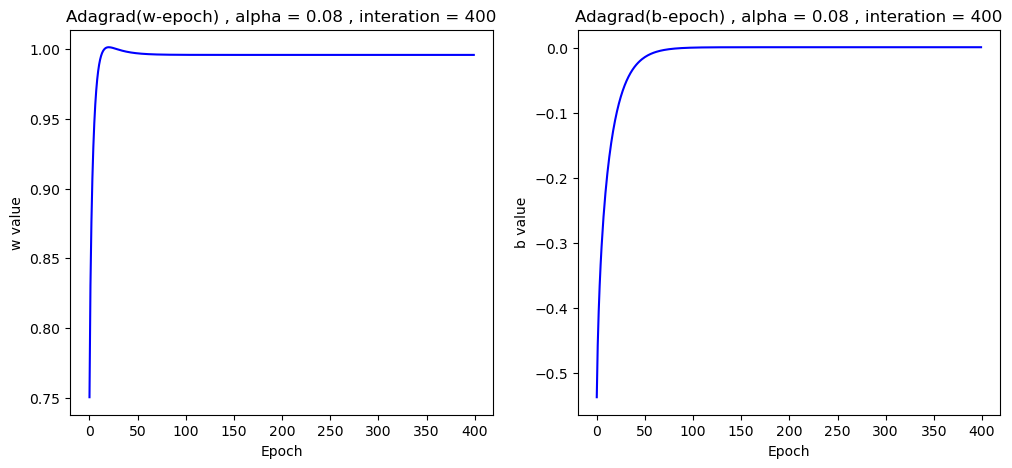

In [41]:
show_epoch_wb_plot(w , b , alpha , interation , optimizer)

In [ ]:
loss_val , interation , alpha_list = compared_different_alpha(optimizer , [0.01 , 0.08 , 0.1] , 400 , X_train , y_train)

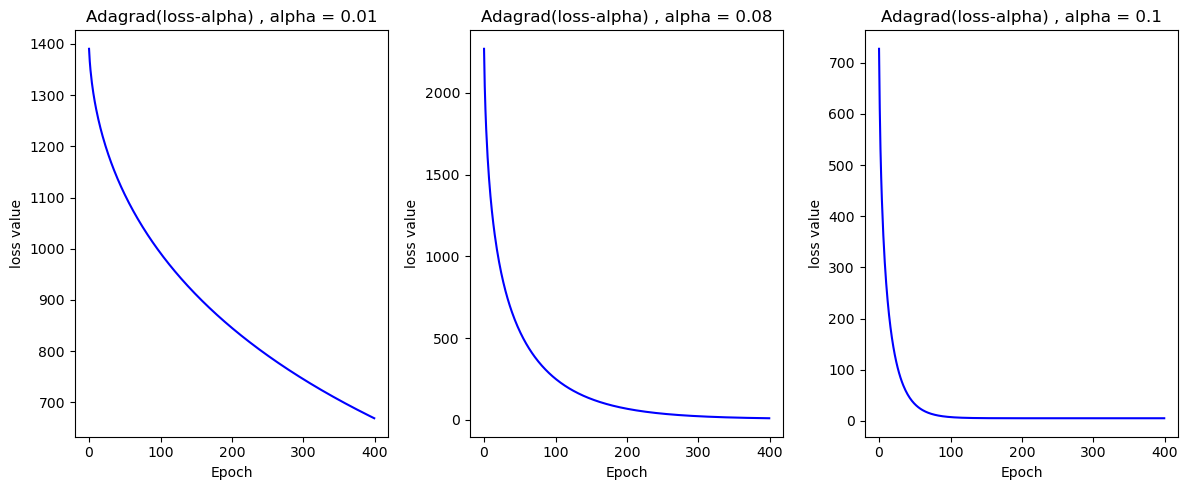

In [43]:
compared_alpha_plot(optimizer , alpha_list , loss_val , interation)

In [ ]:
loss_val , interation , lr = compared_different_epoch(optimizer , [100 , 400 , 1000] , X_train , y_train , 0.08)

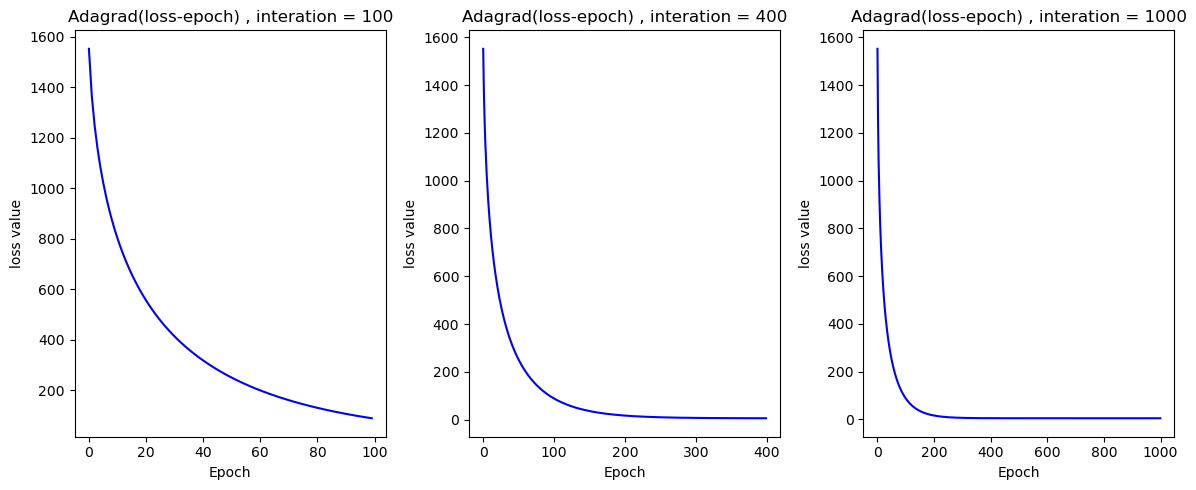

In [45]:
compared_epoch_plot(optimizer  , loss_val , interation)

Adam优化器